In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

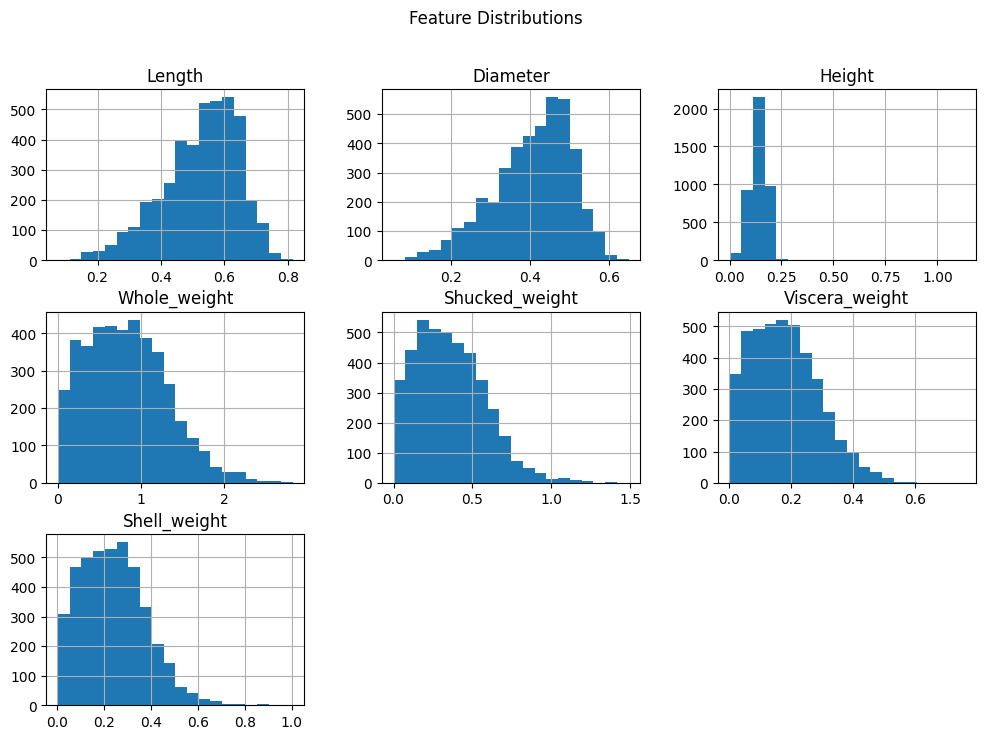

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

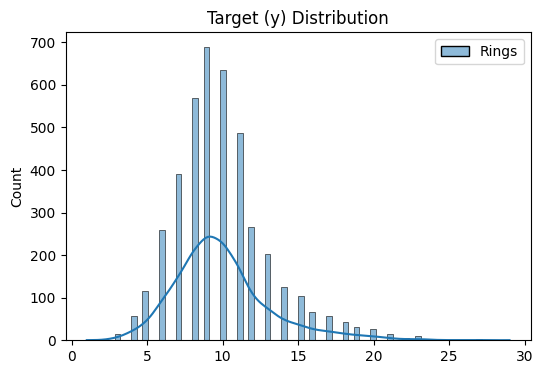

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

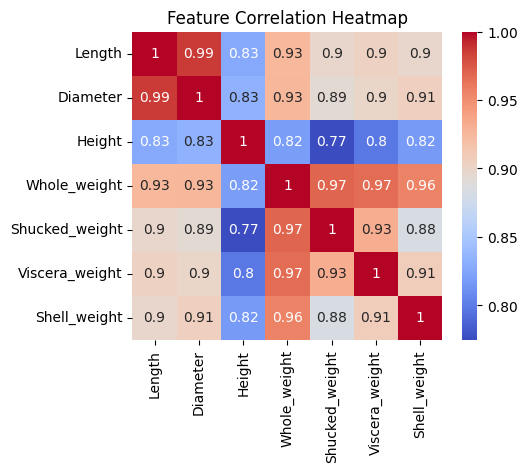

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.146306                 1.084424             1.106866   
1                  1.117778                 1.052268             1.054285   
2                  1.104121                 1.121633             1.222908   
3                  1.041576                 1.096341             1.106131   
4                  1.045333                 1.065918             1.102174   
mean               1.091023                 1.084117             1.118473   
std                0.046033                 0.026938             0.062409   

      DefaultBART_Rhat_RMSE  
0                  1.111170  
1                  1.172634  
2                  1.215420  
3                  1.227008  
4                  1.278941  
mean               1.201035  
std                0.062915  


In [10]:
rhat_df.to_csv("results/real1_Abalone_rhat.csv", index=False)

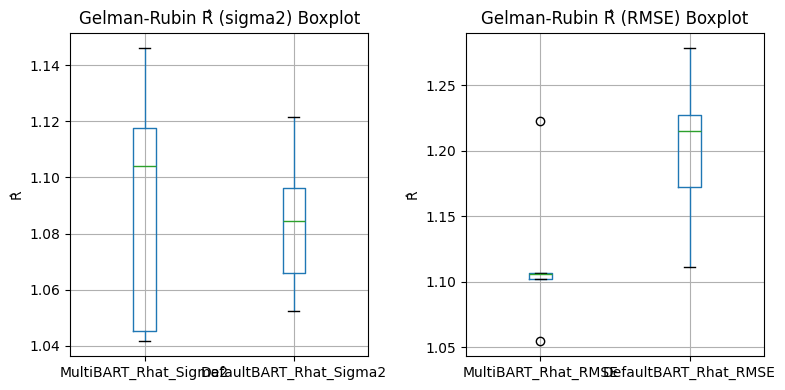

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      4.950381  4.988469  4.903378  4.791655  5.722874
1      4.742502  4.739308  4.814521  4.574730  5.348410
2      5.274147  5.375862  5.341948  5.399027  5.810473
3      4.559035  4.597135  4.516953  4.645710  5.385919
4      4.458468  4.429484  4.469932  4.558238  5.046336
5      5.140734  5.077842  5.142657  5.052298  5.874977
6      5.165872  5.149329  4.866876  4.946810  5.660102
7      5.326703  5.274694  5.287504  5.139162  5.571136
8      5.146579  5.007960  4.828933  4.887725  5.738235
9      5.265561  5.253102  5.243740  5.280333  5.807626
mean   5.002998  4.989319  4.941644  4.927569  5.596609
std    0.312268  0.309830  0.307377  0.292084  0.261880



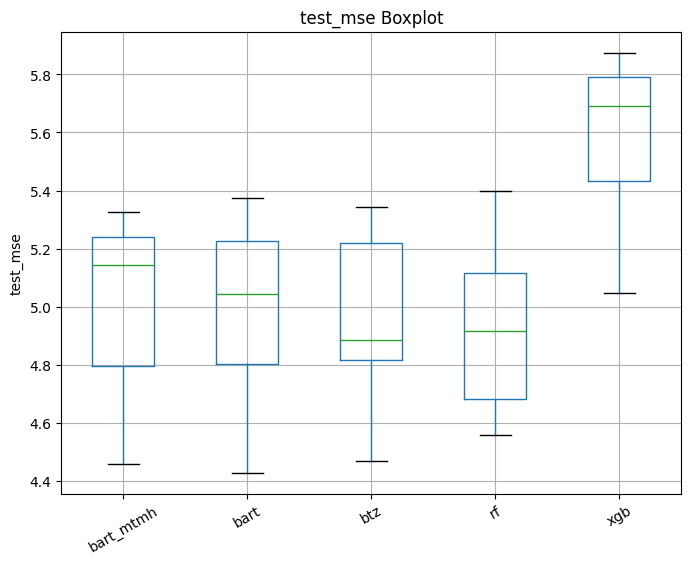

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      3.495525  3.793018  3.907227  0.679427  0.542755
1      3.530571  3.927932  3.998078  0.683244  0.606606
2      3.307039  3.677879  3.762385  0.639765  0.543232
3      3.511354  3.804649  3.964890  0.677036  0.545936
4      3.670182  3.942961  4.066865  0.681703  0.621954
5      3.313324  3.704741  3.831447  0.647193  0.533894
6      3.420686  3.747453  3.914979  0.680122  0.566025
7      3.337760  3.657678  3.772048  0.656752  0.540149
8      3.408126  3.784809  3.909686  0.674107  0.535856
9      3.303662  3.653876  3.734415  0.667631  0.549909
mean   3.429823  3.769500  3.886202  0.668698  0.558632
std    0.121326  0.103365  0.109325  0.015522  0.030849



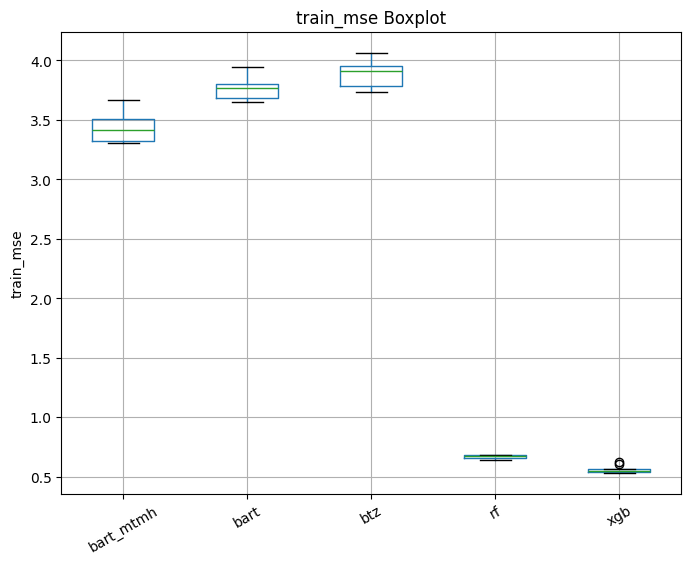

pi_length:
      bart_mtmh      bart       btz
0      8.037198  8.082582  8.332618
1      7.966057  8.213273  8.298976
2      7.849606  7.958014  8.186538
3      8.075064  8.108954  8.292920
4      8.216996  8.293825  8.427382
5      7.869564  7.985721  8.272316
6      7.959084  8.028397  8.313560
7      7.869422  7.955359  8.243681
8      7.903904  8.048337  8.307837
9      7.900066  7.960645  8.157551
mean   7.964696  8.063511  8.283339
std    0.115649  0.114903  0.075949



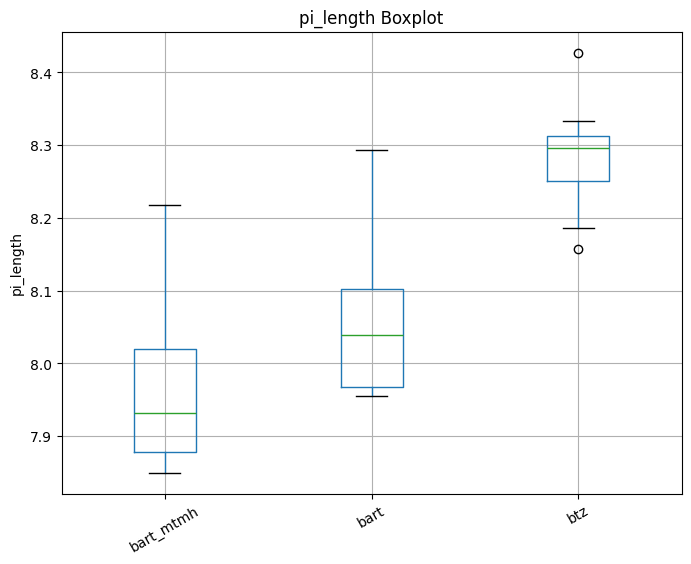

coverage:
      bart_mtmh      bart       btz
0      0.933971  0.933971  0.946411
1      0.933014  0.931100  0.934928
2      0.922488  0.925359  0.924402
3      0.934928  0.931100  0.941627
4      0.942584  0.938756  0.941627
5      0.926316  0.924402  0.930144
6      0.916746  0.913876  0.932057
7      0.913876  0.915789  0.923445
8      0.928230  0.940670  0.933971
9      0.934928  0.928230  0.927273
mean   0.928708  0.928325  0.933589
std    0.008968  0.008810  0.007724



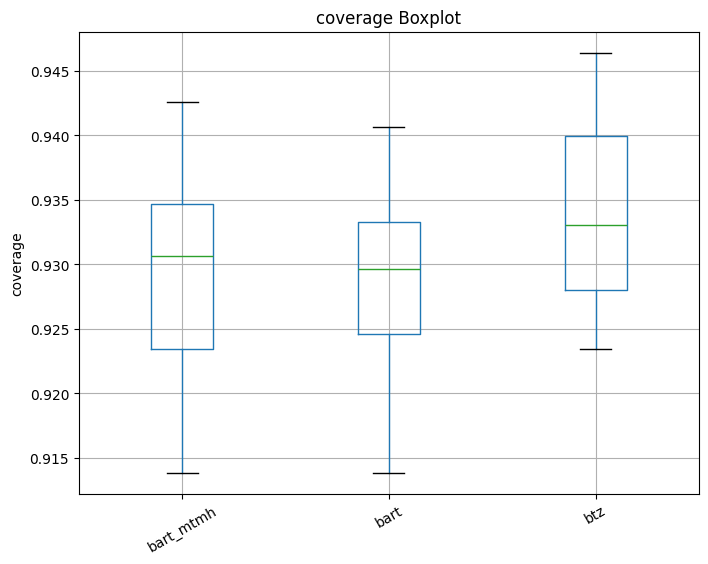

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     135.949554  21.418744  36.412464  1.591418  0.260157
1     135.535185  21.045751  35.356569  1.806937  0.423582
2     138.428476  23.214301  43.852974  1.305346  0.233204
3     135.321917  21.570855  35.463893  1.690739  0.258048
4     135.757342  21.470321  36.120604  1.570832  0.259776
5     138.338781  21.439401  30.223870  1.601315  0.068017
6     139.407527  21.373252  30.314368  1.390184  0.068673
7     139.625296  22.602828  32.183851  1.332782  0.068096
8     138.521033  22.015369  30.912517  1.396820  0.067225
9     138.740660  45.872713  17.143733  1.053794  0.053340
mean  137.562577  24.202353  32.798484  1.474017  0.176012
std     1.709744   7.642435   6.845539  0.219883  0.127846



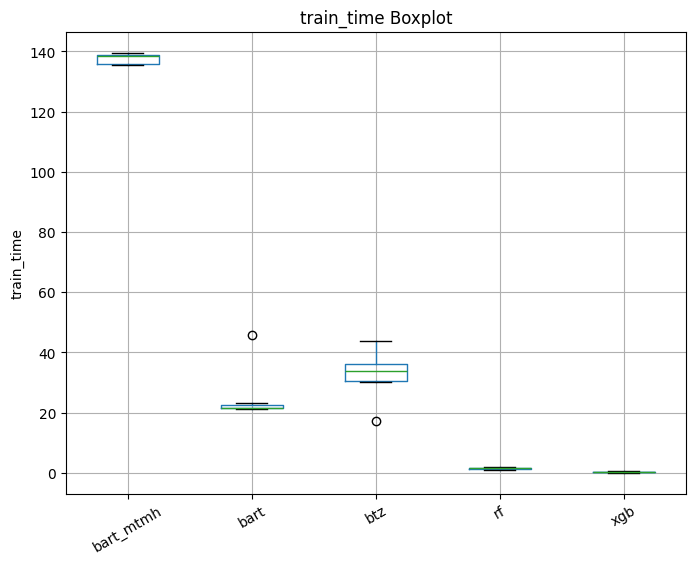

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [11]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real1_Abalone_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real1_Abalone_tries.csv", index=False)

In [12]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage  Train_Time
0            1     1.054701   1.327634  4.814374  0.933971   36.856459
1            5     1.059678   1.200426  4.791194  0.934737   83.957021
2           10     1.091023   1.118473  4.794713  0.933589  137.174760
3           50     1.074219   1.108321  4.819560  0.931483  558.533021
